### Question 3

Using the Mauna Lua CO2 dataset (monthly) perform forecasting using an MLP and compare the results with that of MA (Moving Average) and ARMA (Auto Regressive Moving Average)  models. Main setting: use previous “K” readings to predict next “T” reading. Example, if “K=3” and “T=1” then we use data from Jan, Feb, March and then predict the reading for April. Comment on why you observe such results. For MA or ARMA you can use any library or implement it from scratch. The choice of MLP is up to you.

#### Import the Required Libraries and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import os
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Warning for future updates in pandas library
try:
    import pyarrow
except ImportError:
    %pip install pyarrow
import pandas as pd

try:
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
except ImportError:
    %pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper

In [54]:
def plot_compare_mlp(model, X_train, Y_train, scaler, K, T):
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)

    Y_train_preds = scaler.inverse_transform(model.predict(X_train).reshape(-1, 1)).reshape(-1, T)
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    # for i in range(T):
    plt.plot(Y_train[T-1], label='True {}')
    plt.plot(Y_train_preds[T-1], label='Predicted {}')

    plt.title(f'MLP Model on Dataset with K = {K} and T = {T}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    plt.show()

In [13]:
def plot_compare_arma(model, Y_train, scaler, K, T):
    # Generate predictions
    Y_train_preds = np.empty_like(Y_train)
    for j in range(Y_train.shape[1]):
        model_j = model(Y_train[:, j], order=(1,0,1))  # ARMA model
        model_j_fit = model_j.fit()
        Y_train_preds[:, j] = model_j_fit.predict(start=0, end=Y_train.shape[0]-1)

    # Inverse transform Y_train and Y_train_preds
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)
    Y_train_preds = scaler.inverse_transform(Y_train_preds.reshape(-1, 1)).reshape(-1, T)

    # Calculate loss
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    fig, axs = plt.subplots(Y_train.shape[1], 1, figsize=(10, Y_train.shape[1]*5))

    # Convert axs to a list if it's not already one
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for j in range(Y_train.shape[1]):
        axs[j].plot(Y_train[:, j], label='True {}'.format(j+1))
        axs[j].plot(Y_train_preds[:, j], label='Predicted {}'.format(j+1))
        axs[j].set_title(f'ARMA Model on Dataset with K = {K} and T = {T} - Component {j+1}')
        axs[j].set_xlabel('Time Steps')
        axs[j].set_ylabel('Value')
        axs[j].legend()
        axs[j].text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=axs[j].transAxes)

    plt.tight_layout()
    plt.show()

In [23]:
def plot_compare_ma(model, Y_train, scaler, K, T):
    # Generate predictions
    Y_train_preds = np.empty_like(Y_train)
    for j in range(Y_train.shape[1]):
        model_j = model(Y_train[:, j], order=(0,0,1))  # MA model
        model_j_fit = model_j.fit()
        Y_train_preds[:, j] = model_j_fit.predict(start=0, end=Y_train.shape[0]-1)

    # Inverse transform Y_train and Y_train_preds
    Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).reshape(-1, T)
    Y_train_preds = scaler.inverse_transform(Y_train_preds.reshape(-1, 1)).reshape(-1, T)

    # Calculate loss
    train_loss = mean_squared_error(Y_train, Y_train_preds)

    fig, axs = plt.subplots(Y_train.shape[1], 1, figsize=(10, Y_train.shape[1]*5))
    # Convert axs to a list if it's not already one
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    for j in range(Y_train.shape[1]):
        axs[j].plot(Y_train[:, j], label='True {}'.format(j+1))
        axs[j].plot(Y_train_preds[:, j], label='Predicted {}'.format(j+1))
        axs[j].set_title(f'MA Model on Dataset with K = {K} and T = {T} - Component {j+1}')
        axs[j].set_xlabel('Time Steps')
        axs[j].set_ylabel('Value')
        axs[j].legend()
        axs[j].text(0.95, 0.95, 'Loss: {:.2f}'.format(train_loss), horizontalalignment='right', verticalalignment='top', transform=axs[j].transAxes)

    plt.tight_layout()
    plt.show()

#### Loading and Processing the Given Mauna Lua CO2 Dataset

In [24]:
# Load the dataset
dataset = pd.read_csv('./co2_mm_mlo.csv', comment='#')

# Display the first 5 rows
print(dataset.head())

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99
3  1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99
4  1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99


In [25]:
# Data processing
dataset = dataset[['year', 'month', 'decimal date', 'average', 'deseasonalized']]

print(dataset.head(), end="\n\n")

# Normalize the dataset
scaler = StandardScaler()
dataset['average'] = scaler.fit_transform(dataset[['average']])

print(dataset.head())

   year  month  decimal date  average  deseasonalized
0  1958      3     1958.2027   315.70          314.43
1  1958      4     1958.2877   317.45          315.16
2  1958      5     1958.3699   317.51          314.71
3  1958      6     1958.4548   317.24          315.14
4  1958      7     1958.5370   315.86          315.18

   year  month  decimal date   average  deseasonalized
0  1958      3     1958.2027 -1.372166          314.43
1  1958      4     1958.2877 -1.316538          315.16
2  1958      5     1958.3699 -1.314631          314.71
3  1958      6     1958.4548 -1.323213          315.14
4  1958      7     1958.5370 -1.367080          315.18


In [46]:
# Initial parameters
K = 20
T = 10

# Preparing Train and Test dataset
X_train = np.array([dataset[['average']][i:(i+K)] for i in range(len(dataset)-(K+T)+1)]).reshape(-1, K)
Y_train = np.array([dataset[['average']][(i+K):(i+K+T)] for i in range(len(dataset)-(K+T)+1)]).reshape(-1, T)

# Display the train and test datasets
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")

X_train: (763, 20), Y_train: (763, 10)


In [47]:
X_train

array([[-1.3721661 , -1.31653778, -1.31463052, ..., -1.40077495,
        -1.43129106, -1.44750274],
       [-1.31653778, -1.31463052, -1.32321318, ..., -1.43129106,
        -1.44750274, -1.40045708],
       [-1.31463052, -1.32321318, -1.36708008, ..., -1.44750274,
        -1.40045708, -1.37598061],
       ...,
       [ 1.84474034,  1.76590706,  1.72903343, ...,  1.91117645,
         1.92675238,  1.95281823],
       [ 1.76590706,  1.72903343,  1.7493775 , ...,  1.92675238,
         1.95281823,  1.97475168],
       [ 1.72903343,  1.7493775 ,  1.78339025, ...,  1.95281823,
         1.97475168,  2.04977045]])

In [48]:
Y_train

array([[-1.40045708, -1.37598061, -1.34896114, ..., -1.24851229,
        -1.29333282, -1.36580858],
       [-1.37598061, -1.34896114, -1.33147796, ..., -1.29333282,
        -1.36580858, -1.42080115],
       [-1.34896114, -1.33147796, -1.31240539, ..., -1.36580858,
        -1.42080115, -1.43160894],
       ...,
       [ 1.97475168,  2.04977045,  2.0704324 , ...,  1.90577256,
         1.95790425,  2.0024069 ],
       [ 2.04977045,  2.0704324 ,  2.06026036, ...,  1.95790425,
         2.0024069 ,  2.03228726],
       [ 2.0704324 ,  2.06026036,  2.00145328, ...,  2.0024069 ,
         2.03228726,  2.08791558]])

In [49]:
mlp = MLPRegressor(hidden_layer_sizes=[256, 64, 32], max_iter=1, warm_start=True, random_state=42)

In [50]:
# Train the model for 10000 epochs, printing the loss every 1000 epochs
for i in range(2000):
    mlp.fit(X_train, Y_train)
    if (i+1) % 500 == 0:
        predictions = mlp.predict(X_train)
        loss = mean_squared_error(Y_train, predictions)
        print(f'Loss at epoch {i+1}: {loss}')

Loss at epoch 500: 0.0005406818765597505
Loss at epoch 1000: 0.00039959573823192246
Loss at epoch 1500: 0.0003943456654008073
Loss at epoch 2000: 0.0003392694503560428


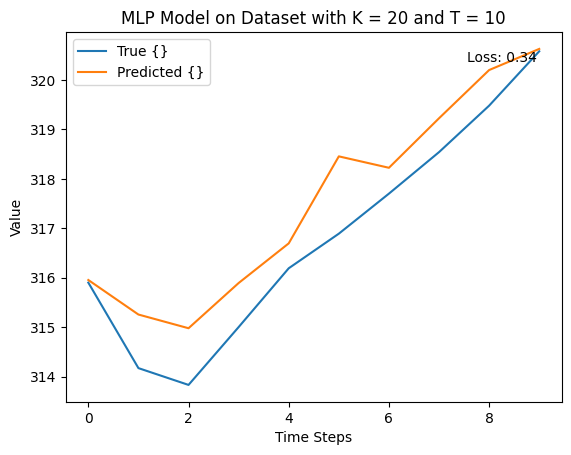

In [55]:
# Plot the datasets
plot_compare_mlp(mlp, X_train, Y_train, scaler, K, T)

### ARMA Model

The ARMA (Autoregressive Moving Average) model is a blend of autoregression (AR) and moving average (MA) components. It's designed to encapsulate both the time series' internal temporal dependencies and the effects of past shocks. An ARMA model of order (p, q), also expressed as ARMA(p, q), can be depicted as:

$$
y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i}
$$

Where:
- $y_t$ represents the time series value at time $t$,
- $\epsilon_t$ is the error term (white noise) at time $t$,
- $\mu$ is the series' mean,
- $\phi_1, \phi_2, \cdots, \phi_p$ are the model's autoregressive parameters, capturing the relationship between the current observation and its past values up to order $p$,
- $\theta_1, \theta_2, \cdots, \theta_q$ are the model's moving average parameters, capturing the impact of past shocks up to order $q$,
- $p$ is the autoregressive component's order, indicating the number of lagged observations included in the model, and
- $q$ is the moving average component's order, indicating the number of lagged forecast errors included in the model.

### Functioning of ARMA Models

1. **Autoregressive Component**: This part of the model encapsulates the linear relationship between the current observation and its past values. It postulates that the series' current value can be expressed as a linear combination of its past values, weighted by the autoregressive parameters $\phi_i$.

2. **Moving Average Component**: This part of the model encapsulates the impact of past shocks on the series' current value. It postulates that the series' current value can be expressed as a linear combination of past forecast errors (the discrepancy between the observed and predicted value), weighted by the moving average parameters $\theta_i$.

3. **Forecasting**: ARMA models leverage past observations and past forecast errors to predict the series' future values. By merging both the autoregressive and moving average components, the model strives to encapsulate both the data's short-term fluctuations and long-term trends.

### Consequences

- ARMA models are adaptable and can encapsulate a broad spectrum of temporal patterns in the data.
- They are especially beneficial when the series displays both autoregression (dependency between current and past values) and moving average behavior (impact of past shocks on current observations).

c:\Users\jayjk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


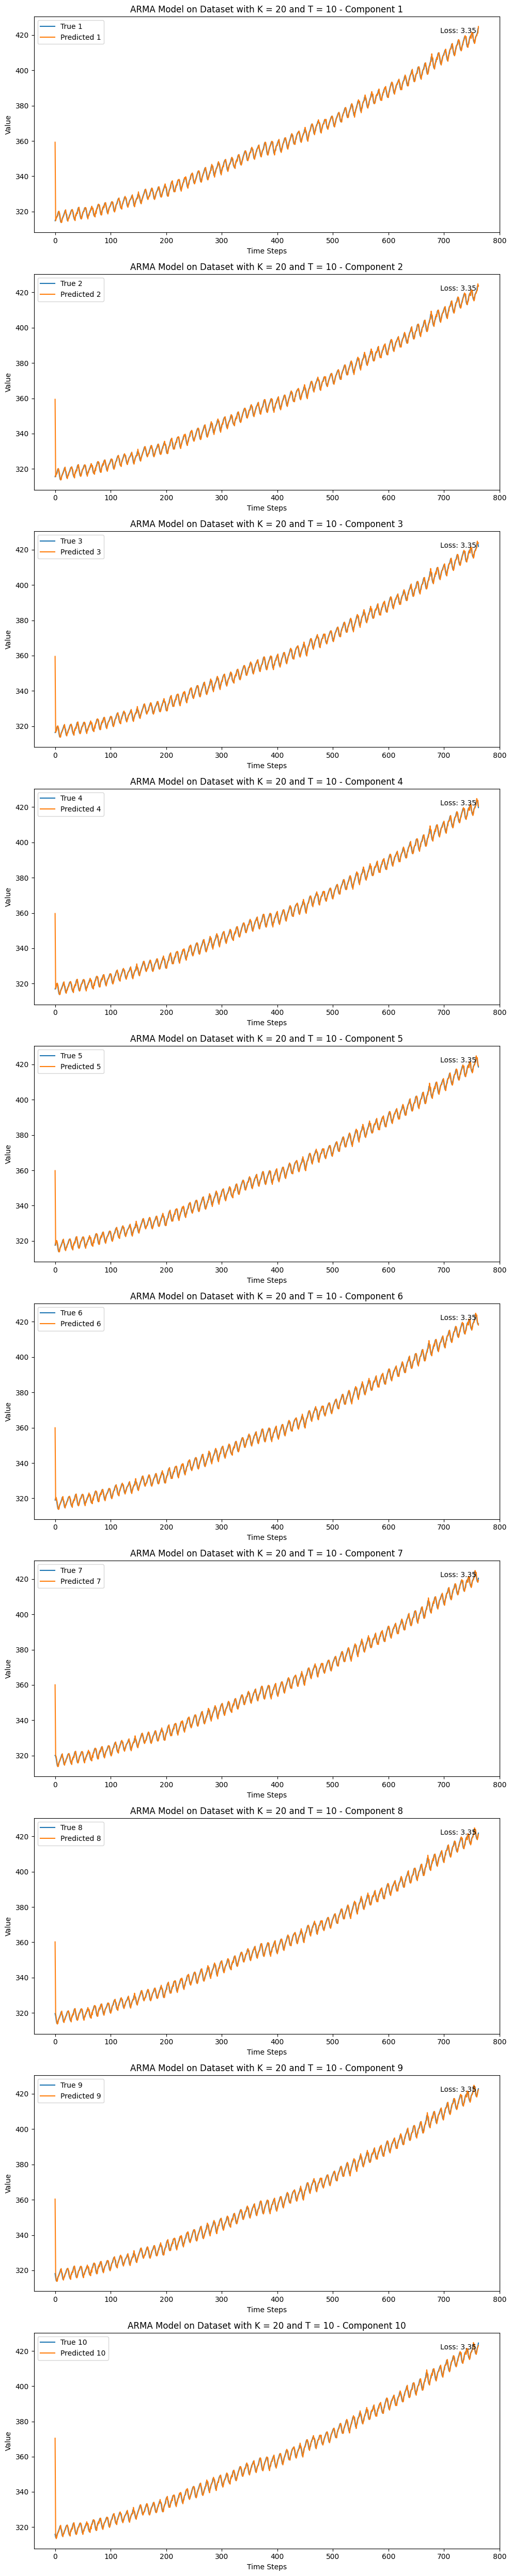

In [52]:
# Fit an ARMA model and plot the results
plot_compare_arma(ARIMA, Y_train, scaler, K, T)

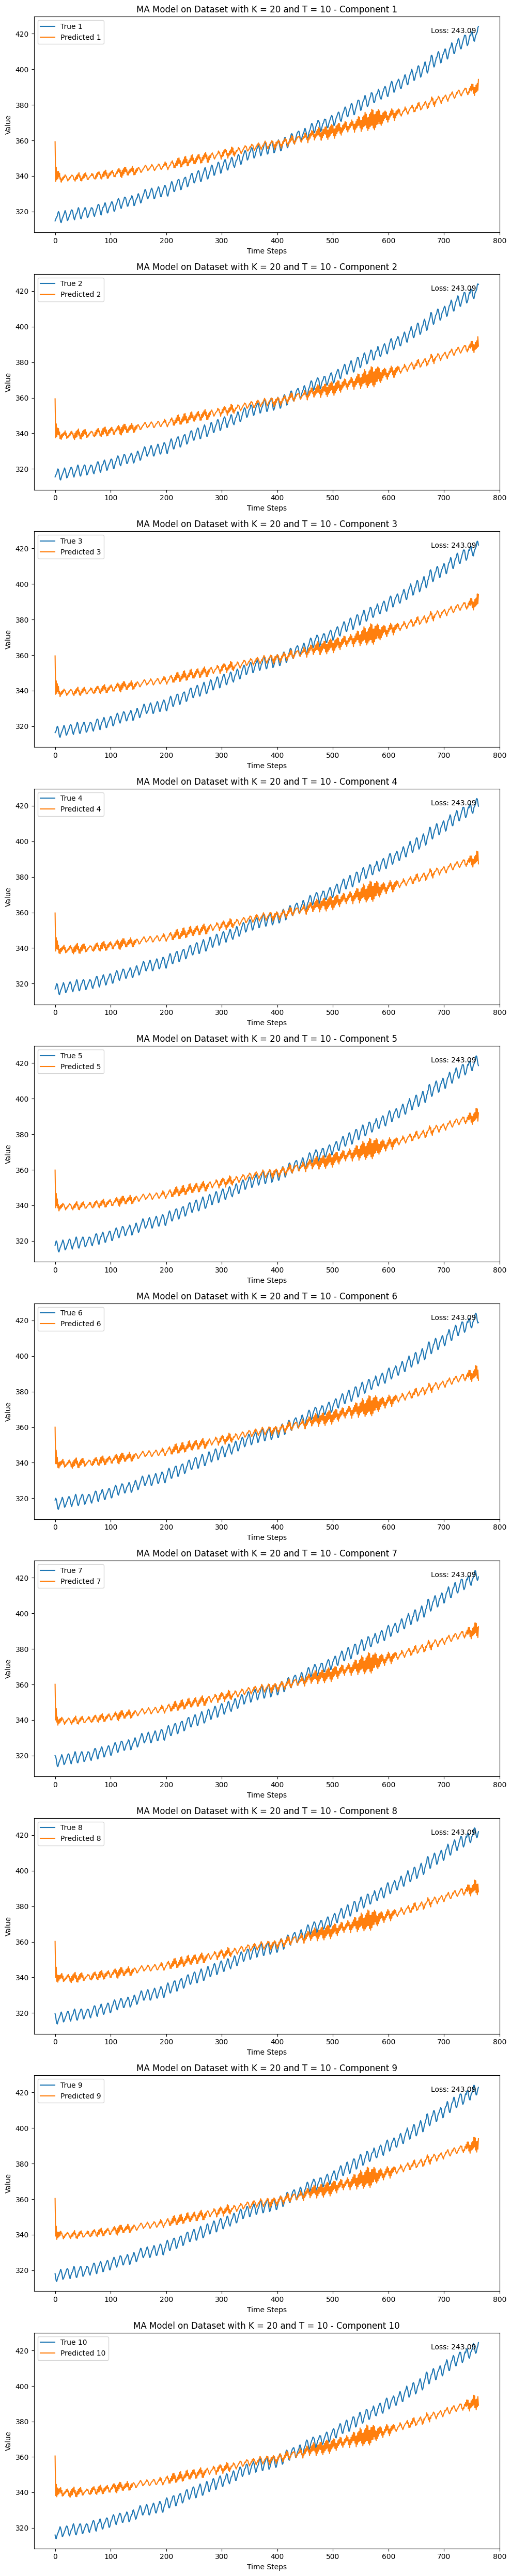

In [53]:
# Fit an MA model and plot the results
plot_compare_ma(ARIMA, Y_train, scaler, K, T)